In [22]:
# ==============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import pandas as pd
import numpy as np
import datetime as dt
import warnings
from pathlib import Path

# Preprocesamiento y Reducción de Dimensionalidad
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap # Usar umap-learn

# Modelos de Clustering
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth

# Métricas de Evaluación de Clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Búsqueda de Hiperparámetros y Utilidades
from sklearn.model_selection import GridSearchCV, ParameterGrid
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [23]:
### CORREGIDO Y MEJORADO ###
def load_and_clean_data(filepath: str) -> pd.DataFrame:
    """
    Carga los datos desde un archivo, realiza la limpieza inicial según los
    requisitos del proyecto. Esta versión es más robusta para evitar errores.

    Args:
        filepath (str): Ruta al archivo de datos.

    Returns:
        pd.DataFrame: DataFrame limpio y listo para el siguiente paso.
    """
    print("--- 1. Cargando y limpiando datos... ---")

    # Cargar los datos. A veces, los archivos de Excel pueden tener problemas de codificación.
    try:
        df = pd.read_excel(filepath)
    except Exception as e:
        print(f"Error al leer el archivo Excel: {e}")
        # Intentar con un motor diferente si falla
        try:
            print("Intentando con el motor 'openpyxl'...")
            df = pd.read_excel(filepath, engine='openpyxl')
        except Exception as e_alt:
            print(f"No se pudo leer el archivo: {e_alt}")
            return pd.DataFrame() # Devolver un DataFrame vacío en caso de fallo total

    # Verificación de columnas esenciales
    required_columns = ['InvoiceNo', 'CustomerID', 'Quantity', 'UnitPrice', 'InvoiceDate']
    if not all(col in df.columns for col in required_columns):
        print("Error: Faltan una o más columnas requeridas en el archivo.")
        print(f"Columnas encontradas: {df.columns.tolist()}")
        return pd.DataFrame()

    # --- Limpieza de Datos ---

    # PASO 1: Eliminar filas sin CustomerID.
    # Esta es la línea crítica. Nos aseguramos de usar `subset=` explícitamente.
    df.dropna(subset=['CustomerID'], inplace=True)

    # PASO 2: Convertir CustomerID a entero y luego a string para evitar problemas de formato.
    df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

    # PASO 3: Filtrar devoluciones y transacciones inválidas.
    # Convertimos InvoiceNo a string para un filtrado seguro con .str
    df['InvoiceNo'] = df['InvoiceNo'].astype(str)
    df = df[~df['InvoiceNo'].str.startswith('C')]
    df = df[df['Quantity'] > 0]
    df = df[df['UnitPrice'] > 0]

    # PASO 4: Eliminar filas completamente duplicadas.
    # El uso correcto no requiere argumentos si queremos comparar todas las columnas.
    df.drop_duplicates(inplace=True)

    # PASO 5: Convertir InvoiceDate a formato de fecha (si no se hizo ya)
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    print(f"Datos limpios. Shape final: {df.shape}")

    # Resetear el índice después de tantas eliminaciones es una buena práctica.
    df.reset_index(drop=True, inplace=True)

    return df

In [24]:
def create_aggregated_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea la tabla agregada por cliente con las métricas RFM+ (Recency, Frequency,
    Monetary y otras).

    Args:
        df (pd.DataFrame): DataFrame limpio con transacciones.

    Returns:
        pd.DataFrame: Tabla agregada con una fila por cliente.
    """
    print("--- 2. Creando tabla agregada por cliente (RFM+)... ---")

    # Calcular el TotalPrice para cada transacción
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    # Establecer una fecha de "hoy" para calcular la recencia
    # Se usa un día después de la última transacción para asegurar que todas las recencias sean >= 1
    snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

    # Agrupar por cliente
    customer_df = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum',
        'StockCode': 'nunique',
        'Country': 'first' # Opcional, tomamos el primer país registrado
    })

    # Renombrar columnas a los nombres requeridos
    customer_df.rename(columns={
        'InvoiceDate': 'recency',
        'InvoiceNo': 'frequency',
        'TotalPrice': 'monetary_value',
        'StockCode': 'num_unique_products'
    }, inplace=True)

    # Calcular avg_ticket
    customer_df['avg_ticket'] = customer_df['monetary_value'] / customer_df['frequency']

    # Reordenar columnas para mayor claridad
    customer_df = customer_df[[
        'recency', 'frequency', 'monetary_value', 'avg_ticket',
        'num_unique_products', 'Country'
    ]]

    print(f"Tabla agregada creada. Shape: {customer_df.shape}")
    return customer_df


In [30]:
class IdentityReducer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def set_params(self, **params):
        return self

    @property
    def n_components_(self):
        # Esta propiedad es necesaria para que el reporte funcione
        # Se asume que se usa después de fit_transform
        if hasattr(self, 'n_features_in_'):
            return self.n_features_in_
        return None

In [25]:
def silhouette_scorer(estimator, X):
    """
    Scorer personalizado para GridSearchCV que utiliza silhouette_score.
    Está diseñado para problemas de clustering (no supervisados).

    Args:
        estimator: El modelo de clustering a evaluar.
        X: Los datos.

    Returns:
        float: El silhouette score. Devuelve -1 si el clustering no es válido
               (ej., encuentra menos de 2 clusters).
    """
    # Ajusta el modelo a los datos
    estimator.fit(X)

    # Obtiene las etiquetas de los clusters
    if hasattr(estimator, 'labels_'):
        labels = estimator.labels_
    else:
        # Algunos modelos pueden no tener .labels_, aunque es raro en sklearn
        labels = estimator.predict(X)

    # El silhouette score solo está definido si hay entre 2 y n_samples-1 clusters.
    # Si DBSCAN marca todo como ruido (-1) o solo se forma un cluster, la métrica falla.
    # Penalizamos estos casos devolviendo un valor bajo (-1).
    if len(np.unique(labels)) < 2:
        return -1

    return silhouette_score(X, labels)

In [26]:
### CORREGIDO ###
def hyperparameter_search_and_evaluate(X_data: pd.DataFrame,
                                       dim_reduction_configs: dict,
                                       clustering_configs: dict) -> pd.DataFrame:
    """
    Realiza una búsqueda exhaustiva de hiperparámetros para combinaciones de
    reducción de dimensionalidad y algoritmos de clustering. Evalúa cada
    combinación usando métricas de clustering.
    """
    print("\n--- 3. Iniciando búsqueda de hiperparámetros y evaluación... ---")
    results = []

    X_numeric = X_data.select_dtypes(include=np.number)

    for red_name, red_config in dim_reduction_configs.items():
        reducer = red_config['model']
        param_grid_red = red_config['param_grid']

        for params_red in ParameterGrid(param_grid_red):
            print(f"\n--- Evaluando con Reducción: {red_name} | Parámetros: {params_red} ---")

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('reducer', reducer.set_params(**params_red))
            ])

            X_reduced = pipeline.fit_transform(X_numeric)
            n_dims = X_reduced.shape[1]

            # --- CORRECCIÓN CLAVE ---
            # En lugar de usar slices, creamos explícitamente un splitter con
            # arrays de índices. Esto es más robusto.
            # El splitter le dice a GridSearchCV que use todos los datos (índices del 0 a N-1)
            # tanto para el conjunto de entrenamiento como para el de prueba.
            full_dataset_splitter = [(np.arange(X_reduced.shape[0]), np.arange(X_reduced.shape[0]))]

            for clust_name, clust_config in clustering_configs.items():
                clusterer = clust_config['model']
                param_grid_clust = clust_config['param_grid']

                grid_search = GridSearchCV(
                    estimator=clusterer,
                    param_grid=param_grid_clust,
                    scoring=silhouette_scorer,
                    cv=full_dataset_splitter,
                    error_score='raise'
                )

                try:
                    grid_search.fit(X_reduced)

                    best_params = grid_search.best_params_
                    best_score = grid_search.best_score_

                    best_model = grid_search.best_estimator_
                    labels = best_model.labels_

                    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

                    if num_clusters > 1:
                        db_score = davies_bouldin_score(X_reduced, labels)
                        ch_score = calinski_harabasz_score(X_reduced, labels)
                    else:
                        best_score = -1
                        db_score = float('inf')
                        ch_score = 0

                    results.append({
                        'Reduction_Method': red_name,
                        'Reduction_Params': str(params_red),
                        'Dimensions': n_dims,
                        'Clustering_Model': clust_name,
                        'Best_Params': str(best_params),
                        'Num_Clusters': num_clusters,
                        'Silhouette_Score': best_score,
                        'Davies_Bouldin_Index': db_score,
                        'Calinski_Harabasz_Score': ch_score,
                    })

                    print(f"  > {clust_name}: OK | Best Silhouette: {best_score:.3f}")

                except Exception as e:
                    print(f"  > {clust_name}: ERROR - {e}")
                    results.append({
                        'Reduction_Method': red_name, 'Reduction_Params': str(params_red),
                        'Dimensions': n_dims, 'Clustering_Model': clust_name,
                        'Best_Params': f'ERROR: {type(e).__name__}', 'Num_Clusters': 0,
                        'Silhouette_Score': -1, 'Davies_Bouldin_Index': float('inf'),
                        'Calinski_Harabasz_Score': 0
                    })

    return pd.DataFrame(results)

In [68]:
def print_results_table(results_df: pd.DataFrame):
    """
    Imprime una tabla formateada con los resultados de la evaluación.

    Args:
        results_df (pd.DataFrame): DataFrame con los resultados.
    """
    print("\n" + "="*120)
    print("TABLA RESUMEN DE RESULTADOS DE CLUSTERING")
    print("="*120)

    # Ordenar por la métrica principal (Silhouette Score) de forma descendente
    df_sorted = results_df.sort_values('Silhouette_Score', ascending=False).round(3)

    #print(df_sorted)
    print(tabulate(df_sorted, headers='keys', tablefmt='grid', showindex=False,maxcolwidths=20))

    print("\n" + "="*120)
    print("MEJORES MODELOS POR MÉTRICA")
    print("="*120)

    if not df_sorted.empty:
        # Mejor por Silhouette (mayor es mejor)
        best_silhouette = df_sorted.iloc[0]
        print(f"\nMejor Silhouette Score: {best_silhouette['Silhouette_Score']:.3f}")
        print(f"  - Combinación: {best_silhouette['Reduction_Method']} + {best_silhouette['Clustering_Model']}")
        print(f"  - Parámetros: {best_silhouette['Best_Params']}")

        # Mejor por Davies-Bouldin (menor es mejor)
        best_db = results_df.sort_values('Davies_Bouldin_Index', ascending=True).iloc[0]
        print(f"\nMejor Davies-Bouldin Index: {best_db['Davies_Bouldin_Index']:.3f}")
        print(f"  - Combinación: {best_db['Reduction_Method']} + {best_db['Clustering_Model']}")
        print(f"  - Parámetros: {best_db['Best_Params']}")

        # Mejor por Calinski-Harabasz (mayor es mejor)
        best_ch = results_df.sort_values('Calinski_Harabasz_Score', ascending=False).iloc[0]
        print(f"\nMejor Calinski-Harabasz Score: {best_ch['Calinski_Harabasz_Score']:.3f}")
        print(f"  - Combinación: {best_ch['Reduction_Method']} + {best_ch['Clustering_Model']}")
        print(f"  - Parámetros: {best_ch['Best_Params']}")


def visualize_best_clusters(X_data: pd.DataFrame, best_config: dict):
    """
    Visualiza los clusters de la mejor configuración encontrada.

    Args:
        X_data (pd.DataFrame): La tabla agregada original.
        best_config (dict): Fila del DataFrame de resultados correspondiente al mejor modelo.
    """
    print("\n--- 4. Visualizando y analizando los mejores clusters... ---")

    # Recrear el pipeline con la mejor configuración
    X_numeric = X_data.select_dtypes(include=np.number)

    # Obtener los modelos y parámetros de la mejor configuración
    # Necesitamos evaluar las cadenas para obtener los objetos/dict
    red_method = dim_reduction_configs[best_config['Reduction_Method']]['model']
    red_params = eval(best_config['Reduction_Params'])

    clust_method = clustering_configs[best_config['Clustering_Model']]['model']
    clust_params = eval(best_config['Best_Params'])

    # Construir y ajustar el pipeline de reducción
    pipeline_red = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', red_method.set_params(**red_params))
    ])
    X_reduced = pipeline_red.fit_transform(X_numeric)

    # Ajustar el modelo de clustering
    clusterer = clust_method.set_params(**clust_params)
    labels = clusterer.fit_predict(X_reduced)

    # Añadir las etiquetas de cluster al DataFrame original
    X_data['Cluster'] = labels

    # --- Gráfico 2D de los Clusters ---
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=X_reduced[:, 0],
        y=X_reduced[:, 1],
        hue=labels,
        palette=sns.color_palette("hsv", n_colors=len(set(labels))),
        legend="full"
    )
    plt.title(f"Visualización de Clusters ({best_config['Reduction_Method']} + {best_config['Clustering_Model']})", fontsize=16)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.show()

    # --- Tabla Resumen con Valores Promedio por Grupo ---
    # Hacemos una copia para no modificar el DataFrame original que se pasa a la función
    X_data_copy = X_data.copy()
    X_data_copy['Cluster'] = labels

    # Para contar el número de clientes, podemos usar cualquier columna que no tenga nulos.
    # El CustomerID está en el índice, así que lo manejamos de forma diferente.
    # Opcionalmente, podemos resetear el índice para que CustomerID se vuelva una columna.
    # Vamos a usar la segunda opción, que es más explícita.

    X_data_with_id_col = X_data_copy.reset_index()

    cluster_summary = X_data_with_id_col.groupby('Cluster').agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary_value': 'mean',
        'avg_ticket': 'mean',
        'num_unique_products': 'mean',
        'CustomerID': 'count' # Ahora 'CustomerID' es una columna y podemos contarla
    }).rename(columns={'CustomerID': 'Num_Customers'}).round(2)

    print("\n" + "="*80)
    print("TABLA RESUMEN DE SEGMENTOS (VALORES PROMEDIO POR CLUSTER)")
    print("="*80)
    print(tabulate(cluster_summary, headers='keys', tablefmt='grid'))

    print("\nInterpretación de segmentos sugerida:")
    print("- Cluster con baja 'recency', alta 'frequency' y 'monetary_value': Clientes Campeones.")
    print("- Cluster con alta 'recency', baja 'frequency' y 'monetary_value': Clientes en Riesgo/Perdidos.")
    print("- Cluster con alto 'monetary_value' pero baja 'frequency': Clientes de Alto Gasto Ocasionales.")

In [43]:
def plot_and_analyze_cluster(
    X_data: pd.DataFrame,
    reduction_method_name: str,
    reduction_params: dict,
    clustering_model_name: str,
    clustering_params: dict,
    dim_reduction_configs: dict,
    clustering_configs: dict
):
    """
    Genera una visualización y un análisis de una configuración de clustering específica.

    Args:
        X_data (pd.DataFrame): La tabla agregada de clientes (con CustomerID como índice).
        reduction_method_name (str): El nombre del método de reducción ('PCA', 'UMAP', 'None', etc.).
        reduction_params (dict): Diccionario de parámetros para el reductor.
        clustering_model_name (str): Nombre del algoritmo de clustering ('KMeans', 'Agglomerative', etc.).
        clustering_params (dict): Diccionario de parámetros para el clusterer.
        dim_reduction_configs (dict): El diccionario global de configuración de reducción.
        clustering_configs (dict): El diccionario global de configuración de clustering.
    """
    print("\n" + "="*80)
    print(f"ANALIZANDO COMBINACIÓN: {reduction_method_name} + {clustering_model_name}")
    print(f"Parámetros de Reducción: {reduction_params}")
    print(f"Parámetros de Clustering: {clustering_params}")
    print("="*80)

    # --- 1. Recrear el pipeline con la configuración especificada ---
    X_numeric = X_data.select_dtypes(include=np.number)

    # Obtener los modelos de los diccionarios de configuración
    reducer_model = dim_reduction_configs[reduction_method_name]['model']
    clusterer_model = clustering_configs[clustering_model_name]['model']

    # Construir y ajustar el pipeline de reducción
    pipeline_red = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', reducer_model.set_params(**reduction_params))
    ])
    X_reduced = pipeline_red.fit_transform(X_numeric)

    # Ajustar el modelo de clustering y obtener las etiquetas
    clusterer = clusterer_model.set_params(**clustering_params)
    labels = clusterer.fit_predict(X_reduced)

    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"\nSe encontraron {num_clusters} clusters (y {'ruido' if -1 in labels else 'sin ruido'}).")

    # --- 2. Gráfico 2D de los Clusters ---
    # Solo podemos graficar si la dimensionalidad es 2 o más
    if X_reduced.shape[1] < 2:
        print("No se puede generar un gráfico 2D porque la dimensionalidad reducida es menor a 2.")
    else:
        plt.style.use('dark_background') # Estilo oscuro como en tu ejemplo
        plt.figure(figsize=(14, 9))

        sns.scatterplot(
            x=X_reduced[:, 0],
            y=X_reduced[:, 1],
            hue=labels,
            palette=sns.color_palette("hsv", n_colors=len(set(labels))),
            legend="full"
        )

        plt.title(f"Visualización de Clusters ({reduction_method_name} + {clustering_model_name})", fontsize=16)
        plt.xlabel(f"Componente Principal 1 ({reduction_method_name})")
        plt.ylabel(f"Componente Principal 2 ({reduction_method_name})")
        plt.show()

    # --- 3. Tabla Resumen con Valores Promedio por Grupo ---
    if num_clusters < 1:
        print("\nNo se encontraron clusters válidos para analizar.")
        return

    # Hacemos una copia y preparamos los datos para el análisis
    X_data_copy = X_data.copy()
    X_data_copy['Cluster'] = labels
    X_data_with_id_col = X_data_copy.reset_index()

    # Calculamos el resumen
    cluster_summary = X_data_with_id_col.groupby('Cluster').agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary_value': 'mean',
        'avg_ticket': 'mean',
        'num_unique_products': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Num_Customers'}).round(2)

    print("\n" + "="*80)
    print("TABLA RESUMEN DE SEGMENTOS (VALORES PROMEDIO POR CLUSTER)")
    print("="*80)

    # Imprimimos la tabla formateada
    # Ignoramos el cluster de ruido (-1) si existe para la tabla principal
    if -1 in cluster_summary.index:
        print("--- Segmentos Principales ---")
        print(tabulate(cluster_summary.drop(-1), headers='keys', tablefmt='grid'))
        print("\n--- Puntos de Ruido (Outliers) ---")
        print(tabulate(cluster_summary.loc[[-1]], headers='keys', tablefmt='grid'))
    else:
        print(tabulate(cluster_summary, headers='keys', tablefmt='grid'))

In [31]:
# 1. Configuraciones de Reducción de Dimensionalidad
dim_reduction_configs = {
    'None': {
            'model': IdentityReducer(),
            'param_grid': {} # No tiene parámetros
    },
    'PCA': {
        'model': PCA(random_state=42),
        'param_grid': {'n_components': [2, 3, 4]} # PCA con diferentes número de componentes
    },
    'UMAP': {
        'model': umap.UMAP(random_state=42, n_jobs=1),
        'param_grid': {'n_components': [2, 3], 'n_neighbors': [15, 30]}
    },
    't-SNE': {
        'model': TSNE(random_state=42, n_jobs=1),
        'param_grid': {'n_components': [2, 3], 'perplexity': [30, 50]}
    }
}

# 2. Configuraciones de Algoritmos de Clustering
clustering_configs = {
    'KMeans': {
        'model': KMeans(random_state=42, n_init=10),
        'param_grid': {'n_clusters': [2, 3, 4, 5, 6]}
    },
    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'param_grid': {'n_clusters': [2,3, 4, 5, 6], 'linkage': ['ward', 'complete']}
    },
    'DBSCAN': {
        'model': DBSCAN(n_jobs=-1),
        # DBSCAN requiere un ajuste más cuidadoso de `eps`.
        # Este es un rango inicial de ejemplo.
        'param_grid': {'eps': [0.5, 0.8 , 1.0, 1.5], 'min_samples': [5, 10, 15]}
    },
    'MeanShift': {
        'model': MeanShift(n_jobs=-1),
        # Bandwidth es crítico. Usar `None` permite que estimate_bandwidth lo calcule.
        'param_grid': {'bandwidth': [None, 1.5, 1.6, 2.0]}
    }
}

# --- Flujo de Ejecución del Proyecto ---
path_excel=Path(r'C:\Users\slopez\OneDrive - Celepsa\PyCharm\Maestria\machine_learning\proyecto_2\Online Retail.xlsx')
# Paso 1 y 2: Cargar, limpiar y agregar los datos
# Cambia 'Online Retail.xlsx' al nombre de tu archivo
DATA_FILEPATH = path_excel
cleaned_df = load_and_clean_data(DATA_FILEPATH)
customer_data = create_aggregated_table(cleaned_df)

# Paso 3: Ejecutar la búsqueda de hiperparámetros y evaluación
all_results_df = hyperparameter_search_and_evaluate(
    X_data=customer_data,
    dim_reduction_configs=dim_reduction_configs,
    clustering_configs=clustering_configs
)


--- 1. Cargando y limpiando datos... ---
Datos limpios. Shape final: (392692, 8)
--- 2. Creando tabla agregada por cliente (RFM+)... ---
Tabla agregada creada. Shape: (4338, 6)

--- 3. Iniciando búsqueda de hiperparámetros y evaluación... ---

--- Evaluando con Reducción: None | Parámetros: {} ---
  > KMeans: OK | Best Silhouette: 0.918
  > Agglomerative: OK | Best Silhouette: 0.960
  > DBSCAN: OK | Best Silhouette: -1.000
  > MeanShift: OK | Best Silhouette: 0.601

--- Evaluando con Reducción: PCA | Parámetros: {'n_components': 2} ---
  > KMeans: OK | Best Silhouette: 0.934
  > Agglomerative: OK | Best Silhouette: 0.969
  > DBSCAN: OK | Best Silhouette: -1.000
  > MeanShift: OK | Best Silhouette: 0.811

--- Evaluando con Reducción: PCA | Parámetros: {'n_components': 3} ---
  > KMeans: OK | Best Silhouette: 0.919
  > Agglomerative: OK | Best Silhouette: 0.962
  > DBSCAN: OK | Best Silhouette: -1.000
  > MeanShift: OK | Best Silhouette: 0.377

--- Evaluando con Reducción: PCA | Parámetr


TABLA RESUMEN DE RESULTADOS DE CLUSTERING
+--------------------+---------------------+--------------+--------------------+---------------------+----------------+--------------------+------------------------+---------------------------+
| Reduction_Method   | Reduction_Params    |   Dimensions | Clustering_Model   | Best_Params         |   Num_Clusters |   Silhouette_Score |   Davies_Bouldin_Index |   Calinski_Harabasz_Score |
+====================+=====================+==============+====================+=====================+================+====================+========================+===========================+
| PCA                | {'n_components': 2} |            2 | Agglomerative      | {'linkage':         |              2 |              0.969 |                  0.126 |                  1436.77  |
|                    |                     |              |                    | 'complete',         |                |                    |                        |                

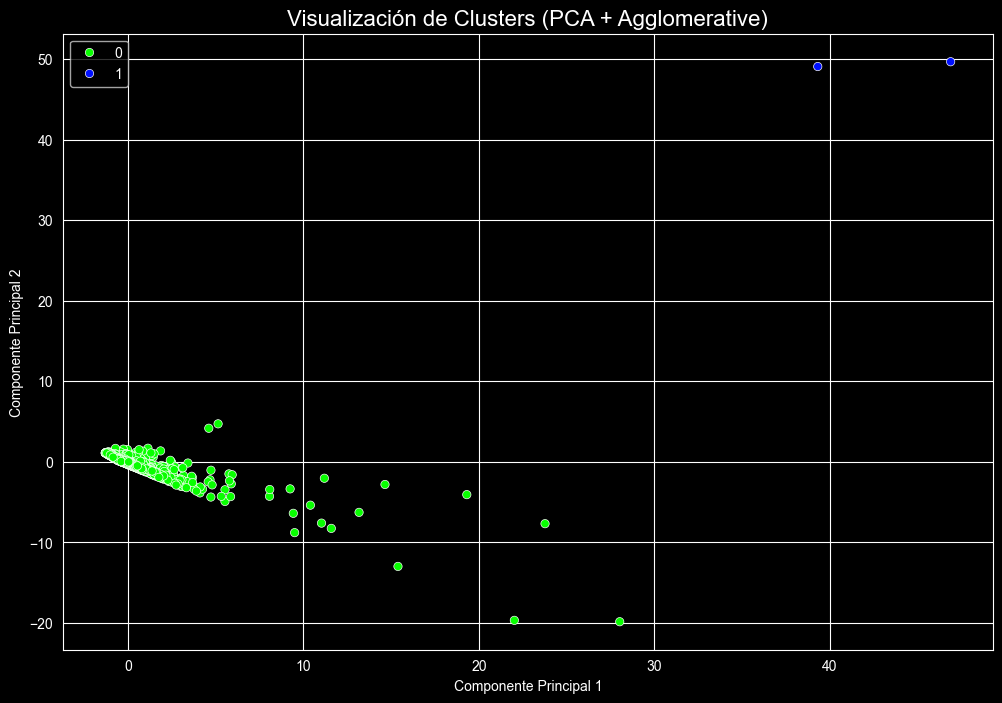


TABLA RESUMEN DE SEGMENTOS (VALORES PROMEDIO POR CLUSTER)
+-----------+-----------+-------------+------------------+--------------+-----------------------+-----------------+
|   Cluster |   recency |   frequency |   monetary_value |   avg_ticket |   num_unique_products |   Num_Customers |
+===========+===========+=============+==================+==============+=======================+=================+
|         0 |      92.5 |        4.27 |          1992.98 |       380.61 |                 61.53 |            4336 |
+-----------+-----------+-------------+------------------+--------------+-----------------------+-----------------+
|         1 |     163.5 |        1.5  |        122828    |     80709.9  |                  2    |               2 |
+-----------+-----------+-------------+------------------+--------------+-----------------------+-----------------+

Interpretación de segmentos sugerida:
- Cluster con baja 'recency', alta 'frequency' y 'monetary_value': Clientes Campeones.
- C

In [69]:
# Paso 4: Imprimir resultados y encontrar el mejor modelo
print_results_table(all_results_df)

# Paso 5: Visualizar y analizar el mejor resultado
if not all_results_df.empty:
    # Seleccionar la mejor combinación basada en Silhouette Score
    best_combination = all_results_df.sort_values(
        'Silhouette_Score', ascending=False
    ).iloc[0].to_dict()

    visualize_best_clusters(customer_data, best_combination)
else:
    print("No se encontraron resultados válidos para visualizar.")


ANALIZANDO COMBINACIÓN: UMAP + DBSCAN
Parámetros de Reducción: {'n_components': 3, 'n_neighbors': 30}
Parámetros de Clustering: {'eps': 0.8, 'min_samples': 5}

Se encontraron 2 clusters (y sin ruido).


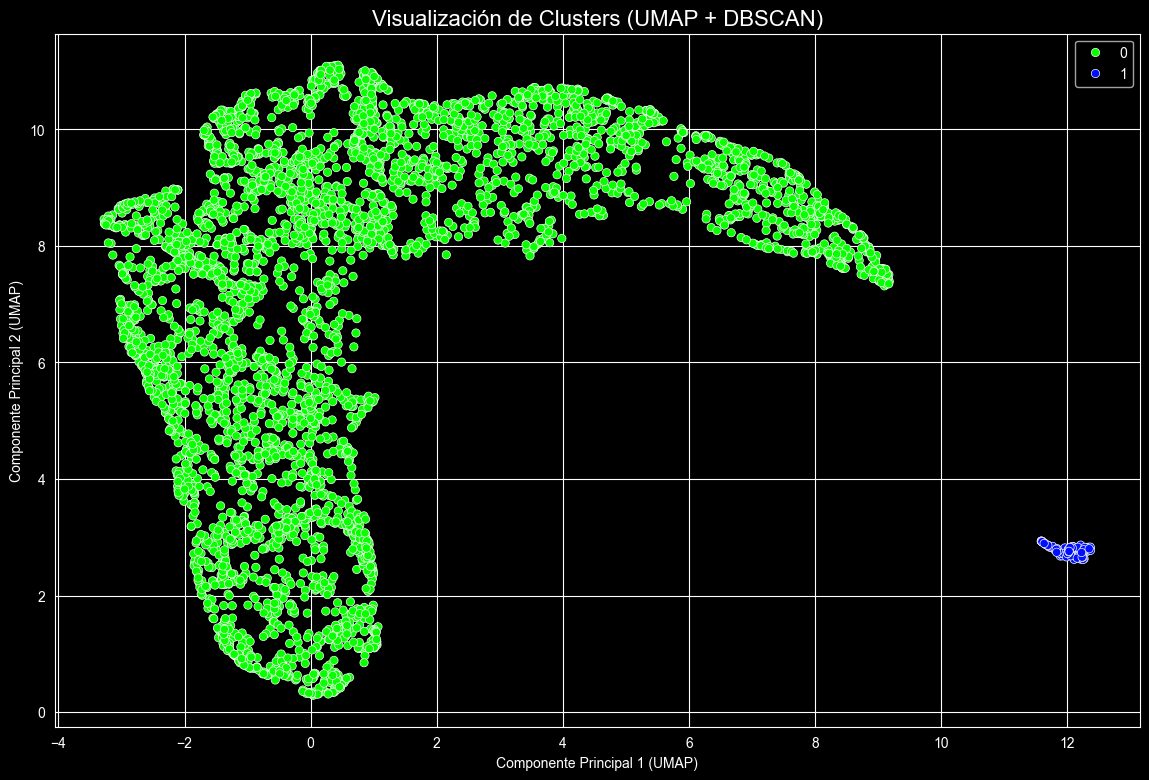


TABLA RESUMEN DE SEGMENTOS (VALORES PROMEDIO POR CLUSTER)
+-----------+-----------+-------------+------------------+--------------+-----------------------+-----------------+
|   Cluster |   recency |   frequency |   monetary_value |   avg_ticket |   num_unique_products |   Num_Customers |
+===========+===========+=============+==================+==============+=======================+=================+
|         0 |     85.02 |        4.36 |          2097.7  |       422.5  |                 62.67 |            4222 |
+-----------+-----------+-------------+------------------+--------------+-----------------------+-----------------+
|         1 |    365.95 |        1.08 |           264.85 |       240.97 |                 19.03 |             116 |
+-----------+-----------+-------------+------------------+--------------+-----------------------+-----------------+


In [78]:
clustering_specific_config_analysis = all_results_df[
        (all_results_df['Clustering_Model'] == 'DBSCAN')
        #&(all_results_df['Reduction_Method'] == 't-SNE')
        #&(all_results_df['Num_Clusters']> 2)
    ].sort_values('Silhouette_Score', ascending=False).iloc[0]

plot_and_analyze_cluster(
        X_data=customer_data,
        reduction_method_name=clustering_specific_config_analysis['Reduction_Method'],
        reduction_params=eval(clustering_specific_config_analysis['Reduction_Params']),
        clustering_model_name=clustering_specific_config_analysis['Clustering_Model'],
        clustering_params=eval(clustering_specific_config_analysis['Best_Params']),
        dim_reduction_configs=dim_reduction_configs,
        clustering_configs=clustering_configs
    )